In [2]:
!python --version
!ls

Python 3.6.10 :: Anaconda, Inc.


RMFD.zip
Untitled.ipynb
self-built-masked-face-recognition-dataset


In [57]:
from glob import glob
from pathlib import Path
import os
import numpy as np
import random
import matplotlib.pyplot as plt

from tensorflow.keras import layers

from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model

from tensorflow.keras.models import save_model

In [6]:
''' Face dataset has more than 90000 images, masked face dataset has around 2000 
     - Randomly remove images from face dataset to balance the sample sizes
         - This will also make training much more faster than before

'''

face_dataset_dir = 'self-built-masked-face-recognition-dataset/AFDB_face_dataset'
    
face_image_paths = glob(os.path.join(face_dataset_dir, '**/*.jpg'), recursive = True)
print(len(face_image_paths))
# face_image_paths[45]
# Number of images to remove from the dataset
# removed_image_counter = 0
# for num in random.sample(range(len(face_image_paths)), 26132 ):
# #     print(num)
#     os.remove(face_image_paths[num])
#     removed_image_counter += 1

print(removed_image_counter)

2200
26132


In [58]:
BASE_LEARNING_RATE = 0.0001
EPOCHS = 2
BATCH_SIZE = 32
IMAGE_SIZE = 160
NUM_OF_CLASSES = 2

In [3]:
# Returns a list of names in list files. 
print("Using glob.glob()") 
dataset_dir= 'self-built-masked-face-recognition-dataset/'
# Search for different file extensions, and concatenate the results 
image_extensions = ['**/*.jpg', '**/*.png']
image_paths = glob(os.path.join(dataset_dir, image_extensions[0]), recursive = True) + glob(os.path.join(dataset_dir, image_extensions[1]), recursive = True)

len(image_paths)

Using glob.glob()


4383

In [20]:
def load_images_and_labels(image_paths):
    '''
        Input  : image paths
        Output : image_data and class labels 
    '''
    
    print('___[LOADING IMAGES]___')
    image_data = []
    labels = []
    
    for image_path in image_paths:
        
        # Get the labels of the images from directory name
        label = os.path.split(image_path)[0].split("\\")[-2]
        labels.append(label)

        # Load the images from the paths
        image = load_img(image_path, target_size=(IMAGE_SIZE,IMAGE_SIZE))
        image = img_to_array(image)
        image = preprocess_input(image)
        image_data.append(image)
        
    # Convert image_data and labels from list to numpy array
    image_data = np.array(image_data)
    labels = np.array(labels)

    print('Image data : {}\nLabels : {}'.format(image_data.shape, labels.shape))
        
    return image_data,labels


In [21]:
image_data, labels = load_images_and_labels(image_paths)

___[LOADING IMAGES]___
Image data : (4383, 160, 160, 3)
Labels : (4383,)


In [22]:
''' Prepare labels for training '''
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

# Perform One-hot-encoding on the labels
# One-hot encoding transforms categorical features 
# to a format that works better with classification 
labels = to_categorical(labels)
labels.shape

(4383, 1)


(4383, 2)

In [54]:
# If variable y is a binary categorical variable 
# with values 0 and 1 and there are 25% of zeros and 75% of ones, 
# stratify=y will make sure that your random split has 25% of 0's and 75% of 1's.
X_train, X_test, y_train, y_test = train_test_split(image_data, labels, test_size=0.25, stratify=labels, random_state=42)
print('Training data : {}, Training labels : {}'.format(X_train.shape, y_train.shape))
print('Testing data : {}, Testing labels : {}'.format(X_test.shape, y_test.shape))

Training data : (3287, 160, 160, 3), Training labels : (3287, 2)
Testing data : (1096, 160, 160, 3), Testing labels : (1096, 2)


In [34]:
''' Data augmentation '''
# The dataset is not just consists of "ideal front-facing face images"   
# But in order to train the model to be more accurate
# even if the position of the head is not ideal
data_aug = ImageDataGenerator(rotation_range = 20,
                             zoom_range = 0.1,
                             width_shift_range = 0.15,
                             height_shift_range = 0.15,
                             shear_range = 0.15,
                             horizontal_flip = True)

In [37]:
''' Create the base model from the pre-trained model MobileNet V2, by following the documentation '''

base_model = MobileNetV2(input_shape = (IMAGE_SIZE,IMAGE_SIZE,3),
                         include_top = False,
                         weights = 'imagenet')

9412608/9406464 [==============================] - 9s 1us/step


In [45]:
print(base_model.output)
print(base_model.input)

Tensor("out_relu/Identity:0", shape=(None, 5, 5, 1280), dtype=float32)
Tensor("input_1:0", shape=(None, 160, 160, 3), dtype=float32)


In [42]:
''' Create new top layers --> for our classification purpose '''
head_model = base_model.output
head_model = layers.AveragePooling2D(pool_size=(5,5))(head_model)
head_model = layers.Flatten()(head_model)
head_model = layers.Dense(128, activation='relu')(head_model)
head_model = layers.Dropout(0.5)(head_model)
head_model = layers.Dense(NUM_OF_CLASSES, activation='softmax')(head_model)

# We will freeze the weights of the base model, so on the training,
# only the weights of the classification model(head model) will be updated 
base_model.trainable = False

In [47]:
''' Connect the base and the head models by using keras.Model '''
# With the "functional API", where you start from Input, 
# you chain layer calls to specify the model's forward pass,
# and finally you create your model from inputs and outputs

# keras.Model is described as above, 
# in our case base_model will be our inputs and head_model will be the output

model = Model(inputs = base_model.input, outputs = head_model)


In [59]:
''' Configure the model and compile the model '''
optimizer = Adam(learning_rate=BASE_LEARNING_RATE)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])


In [70]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
____________________________________________________________________________________________

In [60]:
''' Train the model '''
# We will use the data augmentation method 
# Flow method takes data & label arrays, generates batches of augmented data.

history = model.fit(data_aug.flow(X_train, y_train, batch_size=BATCH_SIZE),
                    steps_per_epoch=len(X_train) // BATCH_SIZE,
                    validation_data=(X_test, y_test),
                    epochs=EPOCHS)

Epoch 1/2
102/102 [==============================] - 80s 789ms/step - loss: 0.2739 - accuracy: 0.8851 - val_loss: 0.0980 - val_accuracy: 0.9653
Epoch 2/2
102/102 [==============================] - 78s 764ms/step - loss: 0.0532 - accuracy: 0.9853 - val_loss: 0.0691 - val_accuracy: 0.9754


In [61]:
predict = model.predict(X_test, batch_size=BATCH_SIZE)
predict = np.argmax(predict, axis=1)

print(classification_report(y_test.argmax(axis=1), predict,
                    target_names=lb.classes_))

                          precision    recall  f1-score   support

       AFDB_face_dataset       1.00      0.95      0.97       550
AFDB_masked_face_dataset       0.95      1.00      0.98       546

                accuracy                           0.98      1096
               macro avg       0.98      0.98      0.98      1096
            weighted avg       0.98      0.98      0.98      1096



In [75]:
model.save('./saved_model/my_model.h5')

In [ ]:
def plot_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

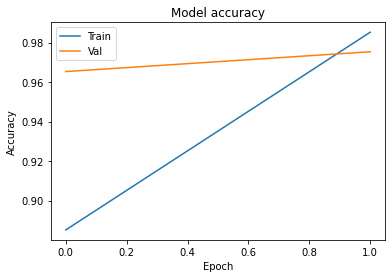

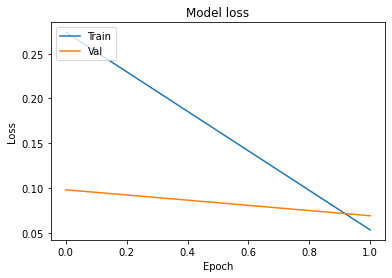

In [71]:
plot_history(history)